# En fiktiv hälsostudie


#### Beskrivande analys
Vi ser i den beskrivande analysen att medelvärden, median, minsta värde och största värdet från de kolumner med numeriska värden. Det skapades även en BMI kolumn för att kunna se hur BMI påverkar sjukdom senare i studien. 3 diagram skapades för att kunna visualisera Blodtrycksvärdet i gruppen. Hur vikten är fördelad mellan män och kvinnor samt hur många rökare och icke rökare det finns. 

#### Kort sjukdoms analys
Vår data visar att 5,9% har sjukdomen för att testa detta gjordes en Monte Carlo-simulering med 1000 observationer. Resultatet pekar på att resultatet från vår data är robust och att den skattade förekomsten är representativ för populationen. 

#### Medelvärde för systolskt blodtryck 
Medelvärdet testades med två olika metoder för konfidensintervall, normalapproximation och bootstrap. Båda metoderna gav i princip identiska resultatet vilket tyder på att normalapproximation är lämplig för detta stickprov och att skattningen av medelvärdet är stabil. 

#### Hypotesprövning: Rökare har högre blodtryck.
För att testa denna hypotes användes ett Welch t-test med alternative greater.  
Vi kan genom vår data se att rökare har något högre blodtryck än icke-rökkare. Dock är resultatet väldigt nära noll och p-värdet är långt över signifikantnivå på 0,05 vilket gör att vi inte kan utesluta att det inte finns någon skillnad mellan gruppernas blodtryck.  
Genom att kolla på power för testet framfick att grupperna skulle behöva vara 28 gånger större för att få ett tillräkligt säkert resultat.

#### Effekter av ålder och kroppsvikt på systoliskt blodtryck
Multipel linjär regression användes för att undersöka hur ålder och kroppsvikt påverkar det systoliska blodtrycket. Metoden visar att ca 40% av variationen kan förklaras av dessa variabler. En ökande ålder gav ett högre systoliskt blodtryck, även kroppsvikt visade en mindre men liknande ökande effekt.

#### Riskfaktorer för sjukdom
Rökning och manligt kön framstår som de största riskfaktorerna för sjukdomen, med över 70 % av den totala riskpåverkan, medan blodtryck, BMI, ålder och kolesterol har små effekter. En logistisk regressionsmodell med standardiserade variabler användes för att uppskatta deras relativa bidrag. Ursprungligen var modellen inte statistiskt signifikant, men med endast de tre starkaste variablerna blev den signifikant, om än med låg prediktionsförmåga.  
Resultaten är instabila och slutsatser bör tolkas försiktigt. Fler deltagare krävs för mer robusta analyser.


In [10]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm

import src.metrics as M 
import src.viz as V 

In [11]:
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "y"

In [12]:
#Importera data & rensar den. 
start_df = pd.read_csv("data/health_study_dataset.csv")   
analys = M.HelthAnalyser(start_df)
df = analys.add_columns(start_df)         

## Beskrivande analys

In [13]:
# Skapar de första analyserna och nya df 
first_analys = analys.analys(df)
df_smoker = analys.smoker(df)
df_num = analys.numeric_variables(df)
display(first_analys)

,age,weight,height,systolic_bp,cholesterol,BMI
mean,49.43,73.41,171.85,149.18,4.93,24.93
median,50.00,73.20,171.35,149.40,4.97,24.70
min,18.00,33.70,144.40,106.80,2.50,12.63
max,90.00,114.40,200.40,185.90,7.88,40.14


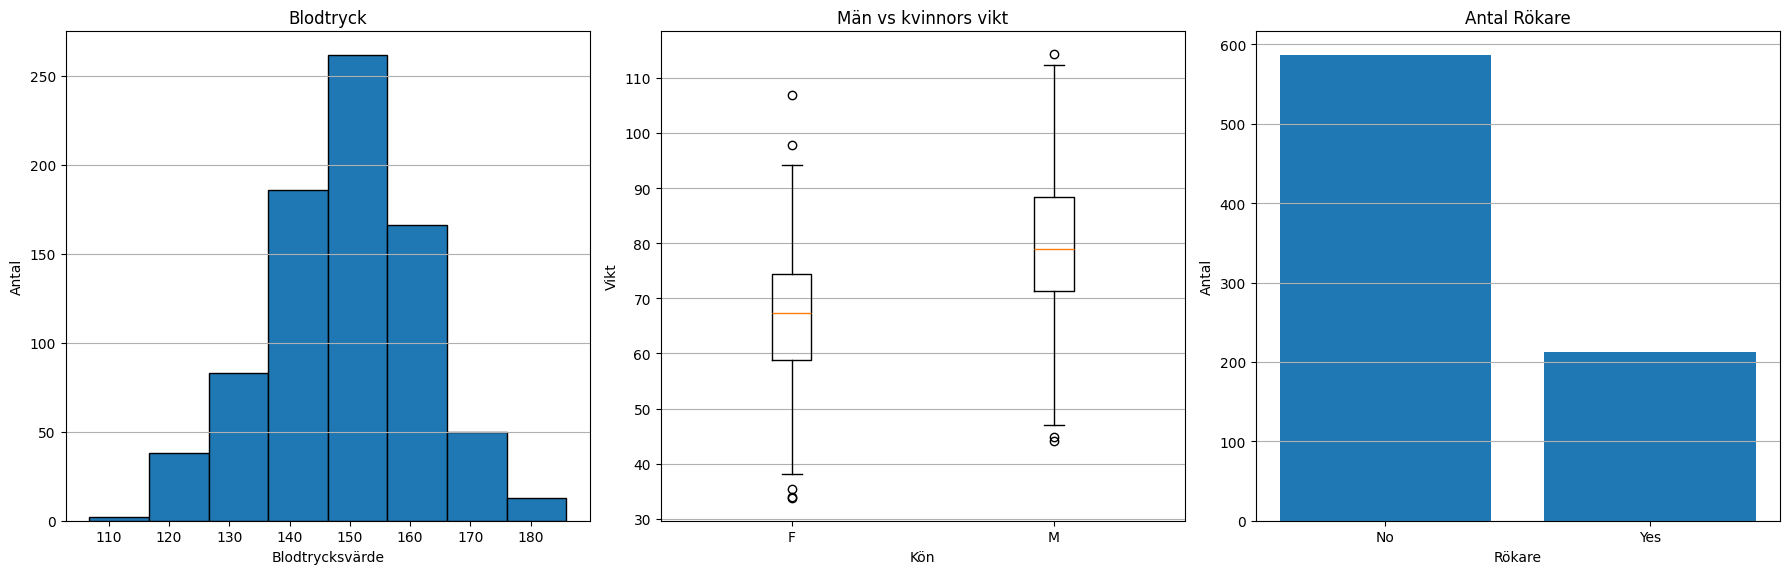

In [14]:
#Visualisering
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

V.histogram(axes[0], df["systolic_bp"], title = "Blodtryck", xlabel = "Blodtrycksvärde" )
V.boxplot(axes[1], [df.loc[df.sex == "F", "weight"], df.loc[df.sex == "M", "weight"]], ["F", "M"], "Män vs kvinnors vikt", "Kön", "Vikt")
V.bar(axes[2], df_smoker.smoker, df_smoker.observations, "Antal Rökare", "Rökare", "Antal")

plt.show()

### I ovan visuaiseringar kan vi från vår data utläsa följande:  
**Diagram 1:** Hur fördelningen av blodtryck ser ut.   
Det är flest i gruppen som har ett blodtryck på runt 150, och det finns en spridning från ca 110 till ca 180.   
**Diagram 2:** Hur fördelningen av vikt ser ut för kvinnor respektive män.   
Kvinnor har generellt en lägre vikt än män. Medelvikten för män ligger strax under 80kg medan medelvikten för kvinnor ligger under 70kg.  
**Diagram 3:** Hur många rökare respektive icke rökare det finns.  
Det är betydligt fler som inte röker än som röker.  

## Simulering
Hur många människor har sjukdomen. 

In [15]:
verklig_andel = df["disease"].mean()

# Simulering
np.random.seed(42)
n = 1000
sim = np.random.choice([0.0, 1.0], p = [1-verklig_andel, verklig_andel], size = n)
simulerad_andel = sim.mean()

print(f"Andel personer som har sjukdomen: {verklig_andel:.2%}")
print(f"Simulerad andel personer som har sjukdomen: {simulerad_andel:.2%}")

Andel personer som har sjukdomen: 5.88%
Simulerad andel personer som har sjukdomen: 5.60%


<Figure size 600x400 with 0 Axes>

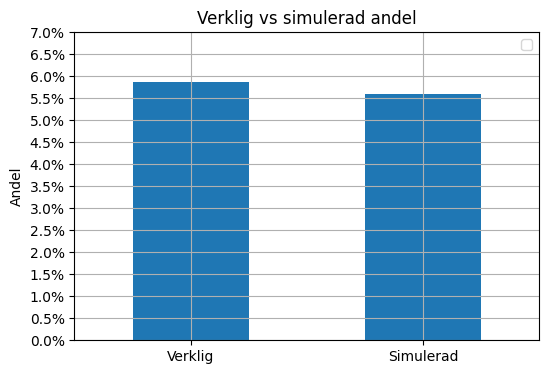

In [16]:
#Skapar en pd.series för visualisering
jämf = pd.Series(
    [verklig_andel, simulerad_andel],
    index=["Verklig", "Simulerad"]
).reset_index()

# Visualisering: 
V.spec_bar(jämf)

Simuleringen ger ett liknande resultat som vår verkliga andel från orginaldatan och skiljer sig endast 0.28% från varandra. 

## Konfidensintervall för blodtryck

### Sammanfattning: 
Konfidensintervallet för de två metoderna (Normal approximation och bootstrap) är i princip lika. 
Stickprovsmedlet ligger väldigt nära medelvärdet från orginaldata och kan därför ses som representativt. 

### Normal approximation

In [17]:
#Tar fram ett stickprov och räknar ut konfidensintervall med hjälp av normalapproximation
np.random.seed(123)

n = 40 
stick= np.random.choice(df.systolic_bp, size= n)
mean_bp = df.systolic_bp.mean()

lo, hi, mean_stick, s, n, se = M.ci_mean_normal(stick)
print (f"Medelvärde finns inom blodtryck: {lo:.2f}, {hi:.2f} \n"
       f"Medelvärde för stickprov: {mean_stick:.2f} \n"
       f"Medelvärde från originaldata: {mean_bp:.2f} \n" 
       f"Standard avvikelse: {s:.2f}\n"
       f"Standardfel: {se:.2f}")   

Medelvärde finns inom blodtryck: 145.06, 153.48 
Medelvärde för stickprov: 149.27 
Medelvärde från originaldata: 149.18 
Standard avvikelse: 13.59
Standardfel: 2.15


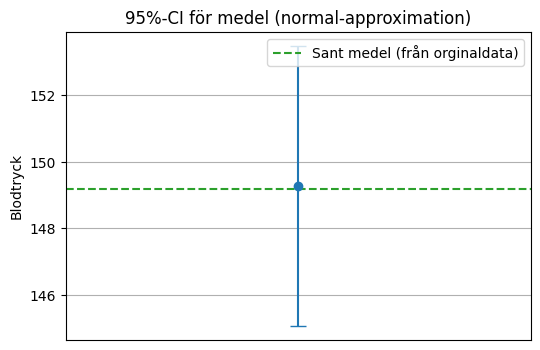

In [18]:
fig, ax = plt.subplots()
V.errorbar(ax, mean_stick, lo, hi, mean_bp)

## Bootstrap test 

In [19]:
b_lo, b_hi, b_mean= M.ci_mean_bootstrap(stick)
print(f"""Mellan {b_lo:.2f} - {b_hi:.2f} kommer medelvärdet finnas 95% av gångerna, 
      Bootstrap medelvärde      : {b_mean:.2f}, 
      Medelvärde från stickprov : {float(mean_bp):.2f}""")

Mellan 145.13 - 153.47 kommer medelvärdet finnas 95% av gångerna, 
      Bootstrap medelvärde      : 149.27, 
      Medelvärde från stickprov : 149.18


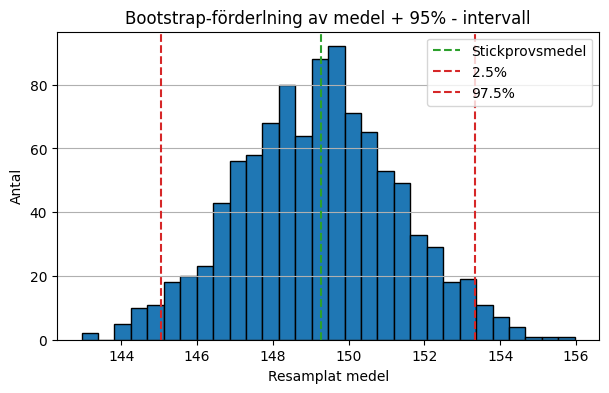

In [20]:
boot_info = np.array([np.mean(np.random.choice(stick, size=len(stick), replace= True)) for _ in range(1000)])
fig, ax = plt.subplots( figsize= (7,4))
V.ax_boot(ax, boot_info, stick)

Diagrammet ovan visar vart medelvärdet för blodtryck hamnar vid 1000 olika stickprov med 40 personer per stickprov.

In [21]:
print(f"Normal-CI: {lo:.2f}, {hi:.2f}")
print(f"Bootstrap-CI: {b_lo:.2f}, {b_hi:.2f}")
print("Stickprovsmedel:", mean_stick, "\nMedelvärde från original data:", mean_bp)

Normal-CI: 145.06, 153.48
Bootstrap-CI: 145.13, 153.47
Stickprovsmedel: 149.27 
Medelvärde från original data: 149.178625


In [22]:
# Testar hur ofta vårt orginal medelvärde fångas av de olika metoderna 
np.random.seed(123)
cov_normal = M.covers_true_mean(df.systolic_bp, mean_bp, "normal", n=40, trials=500)
cov_boot = M.covers_true_mean(df.systolic_bp, mean_bp, "bootstrap", n=40, trials=500)
print(f"""Test för att se hur ofta de olika metoderna fångar vårt medelvärde:  
CI-normal   : {cov_normal:.4f}
CI-bootstrap: {cov_boot:.4f}""")

Test för att se hur ofta de olika metoderna fångar vårt medelvärde:  
CI-normal   : 0.9420
CI-bootstrap: 0.9360


# Hypotesprövning
## Hypotes: Rökare har högre medel-blodtryck än icke-rökare.

### Sammanfattning: 
Rökare har något högre blodtryck än icke-rökkare, men för att få ett tillräkligt säkert resultat skulle grupperna behöva vara 28 gånger större.   
Det innebär att man skulle behöva ungefär 22 400 deltagare för att få ett tillförlitligt resultat och se om det på riktigt finns någon skillnad i blodtryck mellan rökare och icke rökare. 

In [14]:
display(df_smoker)

,smoker,observations,proportions
0,No,587,149.052981
1,Yes,213,149.524883


Metodval: Welch t-test med alternativ greater: Detta då vi jämför två olika stora grupper och antar att rökare har högre blodtryck än den andra. Källa: Joakim Lindh och https://en.wikipedia.org/wiki/Welch%27s_t-test

In [15]:
from scipy import stats

non_smoker = df.loc[df.smoker == "No", "systolic_bp"].values
is_smoker = df.loc[df.smoker == "Yes", "systolic_bp"].values

t_stat_w, p_val_w = stats.ttest_ind(is_smoker, non_smoker, equal_var=False, alternative = "greater")

print(f"Welch t-test: t = {t_stat_w:.3f}, p = {p_val_w:.4f}")

Welch t-test: t = 0.450, p = 0.3264


Positivt t-värde visar att rökare har ett högre medel blodtryck än icke rökare. Dock är resultatet väldigt nära noll och p-värdet är långt över signifikantnivå på 0,05 vilket gör att vi inte kan utesluta att det inte finns någon skillnad mellan gruppernas blodtryck.

In [16]:
def power_by_simulation(n_sim, mean_x, n_x, mean_y, n_y, std, n = 1, alpha= 0.05):
    """ 
    Räknar ut hur mycket power som t-test med hypotesen att y är större än x har
    """
    np.random.seed(7)
    count_significant = 0 
    for _ in range(n_sim):
        x = np.random.normal(mean_x, std, (n_x * n))
        y= np.random.normal(mean_y, std, (n_y *n))
        _, p_val = stats.ttest_ind(y, x, equal_var=False, alternative="greater")
        if p_val < alpha: 
            count_significant += 1
    return count_significant / n_sim

In [17]:
n_sim = 5000
alpha = 0.05 
n_non_smoker = df_smoker["observations"][0]
n_is_smoker = df_smoker["observations"][1]
mean_non_smoker = df_smoker["proportions"][0]
mean_is_smoker = df_smoker["proportions"][1]
std = df["systolic_bp"].std()
n = 1

pwr = power_by_simulation(n_sim, mean_non_smoker, n_non_smoker, mean_is_smoker, n_is_smoker, std, n, alpha)
print(f"Power för observerad skillnad: {pwr}")

Power för observerad skillnad: 0.1136


Med en power på 11,36% kan vi inte dra några säkra slutsatser på att det finns en verklig skillnad mellan gruppernas blodtryck. Ett större deltagar antal behövs för att få ett mer stabilt resultat.

In [18]:
samples_try = [1, 10, 20, 25, 28, 30]
sim_pwr = []
for n in samples_try:
    pwr = power_by_simulation(n_sim, mean_non_smoker, n_non_smoker, mean_is_smoker, n_is_smoker, std, n, alpha)
    sim_pwr.append(pwr)

pd.DataFrame({f"n_non_smoker": n_non_smoker, "n_is_smoker": n_is_smoker, "groupsize_times_n": samples_try, "simulated_power": sim_pwr})

,n_non_smoker,n_is_smoker,groupsize_times_n,simulated_power
0,587,213,1,0.1136
1,587,213,10,0.4286
2,587,213,20,0.6612
3,587,213,25,0.7532
4,587,213,28,0.8054
5,587,213,30,0.8058


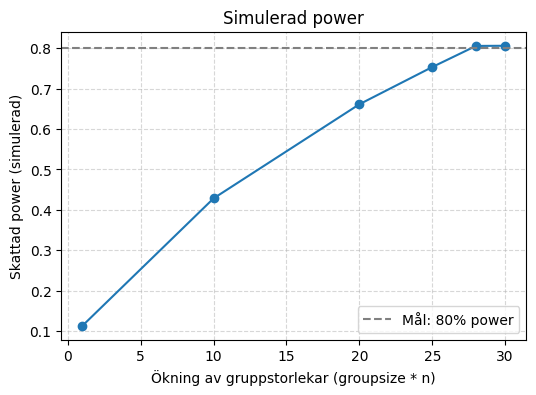

In [19]:
fig, ax = plt.subplots()
V.plot(ax, samples_try, sim_pwr)
plt.show()

In [20]:
pwr_28 = power_by_simulation(n_sim, mean_non_smoker, n_non_smoker, mean_is_smoker, n_is_smoker, std, 28, alpha)
pwr_28

0.8054

In [21]:
need_smokers = n_is_smoker * 28
need_non_smoker = n_non_smoker * 28

need_non_smoker, need_smokers, (need_smokers + need_non_smoker)

(np.int64(16436), np.int64(5964), np.int64(22400))

# Multipel regression   
## Förutsäga blodtryck från ålder och vikt.

### Sammanfattning: 

Det systoliska blodtrycket är beroende av fler kända och okända faktorer. I denna modell förklarar ålder och vikt tillsammans cirka 40% av variationen.  
När vikten ökar med ett kg ökar värdet i snitt med ungefär 0.18. För varje år äldre en männsika blir ökar det systoliska blodtrycket med ungefär 0.54 i snitt från vår data. 
Utan yttre faktorer som ålder och vikt ligger det systoliska blodtrycket i snitt på 109.499. 

För att räkna ut detta har jag valt nedan metod med linear regression, med källa från Joakim Lindhs video och hjälp av Chatgpt för att omvandla den till en multipel regression. 


----- Regression: systolic_bp = a + b1 * age + b2 * weight -----
Skärning blodtryck      :  109.499
Lutning ålder           :  0.5389
Lutning vikt            :  0.1777
R^2                     :  0.405
Tolkning lutning: +10 år => ändrat blodtryck:   5.39 
Tolkning lutning: +10 kg => ändrat blodtryck:   1.78 



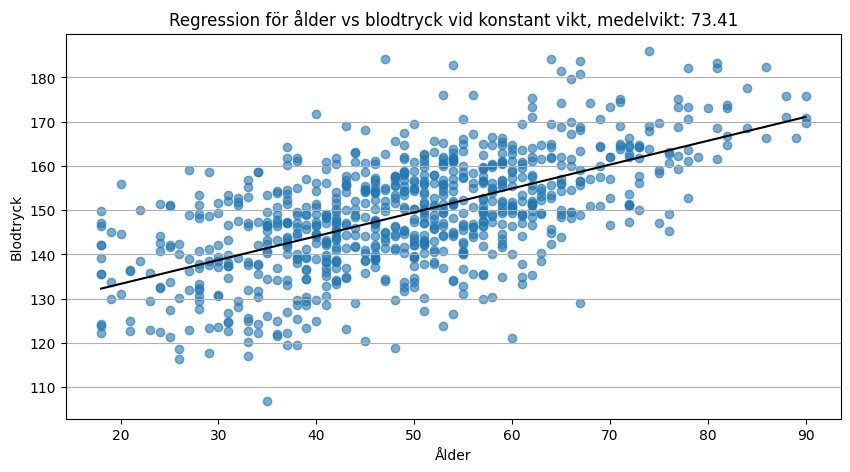

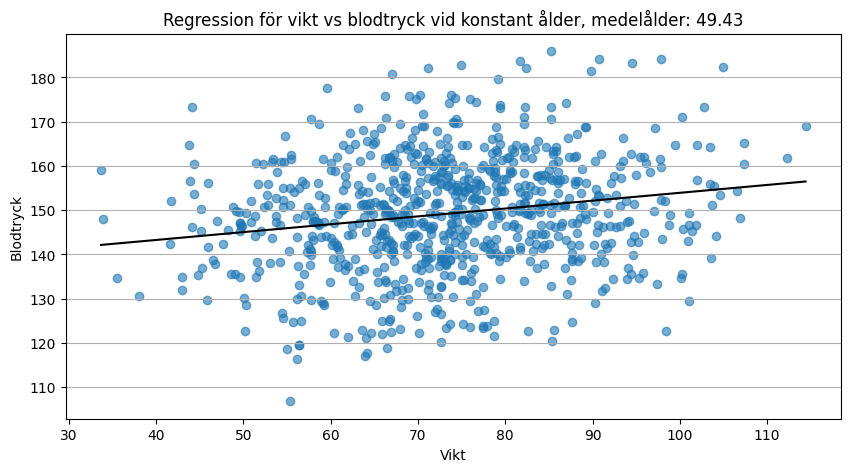

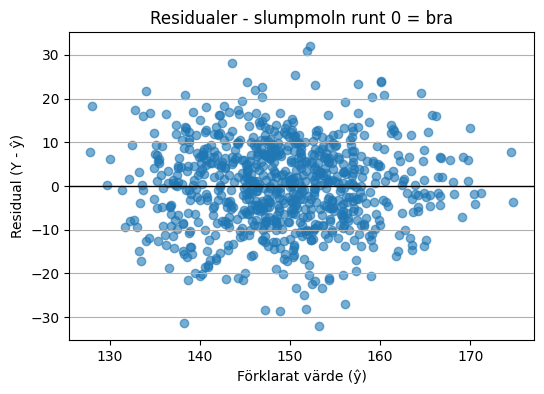

In [22]:
#Multipel regression: 

features = df[["age", "weight"]].to_numpy()

x = features
y = df["systolic_bp"].to_numpy()

model = LinearRegression()
model.fit(x,y)

intercept_hat = float(model.intercept_)
beta_age, beta_weight = model.coef_  

y_hat = model.predict(x)
residuals = y- y_hat

ss_tot = np.sum((y-y.mean())**2)
ss_res = np.sum((residuals)**2)
r2 = 1 - ss_res/ ss_tot

print(f"""
----- Regression: systolic_bp = a + b1 * age + b2 * weight -----
Skärning blodtryck      : {intercept_hat: .3f}
Lutning ålder           : {beta_age: .4f}
Lutning vikt            : {beta_weight: .4f}
R^2                     : {r2: .3f}
Tolkning lutning: +10 år => ändrat blodtryck:  {10 * beta_age: .2f} 
Tolkning lutning: +10 kg => ändrat blodtryck:  {10 * beta_weight: .2f} 
""")

#Visualiseringar 
age_mean = x[:,0].mean()
weight_mean = x[:,1].mean()

fig, ax = plt.subplots(figsize= (10, 5))
ax.scatter(x[:,0], y, alpha = 0.6)
x_line = np.linspace(x[:,0].min(), x[:,0].max(), 100)
y_line = intercept_hat + beta_age * x_line + beta_weight * weight_mean
ax.plot(x_line, y_line, color="black")
ax.set_title(f"Regression för ålder vs blodtryck vid konstant vikt, medelvikt: {weight_mean:.2f}")
ax.set_xlabel("Ålder")
ax.set_ylabel("Blodtryck")
plt.show()


fig, ax = plt.subplots(figsize= (10, 5))
ax.scatter(x[:,1], y, alpha = 0.6)
x_line = np.linspace(x[:,1].min(), x[:,1].max(), 100)
y_line = intercept_hat + beta_weight * x_line + beta_age * age_mean
ax.plot(x_line, y_line, color="black")
ax.set_title(f"Regression för vikt vs blodtryck vid konstant ålder, medelålder: {age_mean:.2f}")
ax.set_xlabel("Vikt")
ax.set_ylabel("Blodtryck")
plt.show()


plt.figure(figsize=(6,4))
plt.scatter(y_hat, residuals, alpha=0.6)
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Förklarat värde (ŷ)")
plt.ylabel("Residual (Y - ŷ)")
plt.title("Residualer - slumpmoln runt 0 = bra")
plt.show()


# Logistisk regression av sjukdom

## Sammanfattning/ Resultat 

Att röka och att vara man framstår som de två största riskfaktorerna för att drabbas av sjukdomen i detta datamaterial. Tillsammans står de för över 70 procent av den totala riskpåverkan i modellen. Blodtryck, BMI, ålder och kolesterol uppvisar däremot relativt små effekter i jämförelse.   

**Metodval:**  
Variablerna standardiserades med StandardScaler och en logistisk regressionsmodell tränades för att uppskatta varje variabels relativa påverkan på sjukdomsrisken.

För att komma igång med modellen tog jag hjälp av ChatGPT och tittade även på scikit-learns dokumentation för LogisticRegression. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html 

### Tillförlitlighet: 
Med ett p-värde på 0.2047 och en korsvaliderad AUC på 0.53 ± 0.17 kan resultaten inte betraktas som statistiskt tillförlitliga, eftersom modellens prediktionsförmåga inte skiljer sig från slumpen.

### Reducerade testvariabler 
Jag väljer att reducera antalet variabler för att se om modellen kan bli statistisk säkerställd och väljer de tre med högst värden från testet innan.  
Med endast tre variabler blir modellen statistiskt signifikant (LLR p = 0.046), vilket tyder på att de har ett gemensamt samband med sjukdomsrisken. Prediktionsförmågan är dock låg (AUC ≈ 0.57 ± 0.16) och resultaten är instabila mellan olika delmängder, vilket gör att slutsatserna bör tolkas med försiktighet.

För att kunna tolka datan korrekt bör därför fler deltagare samlas in.

smoker         0.285498
male           0.254171
systolic_bp    0.069065
BMI            0.051509
age            0.051103
cholesterol   -0.020668
dtype: float64


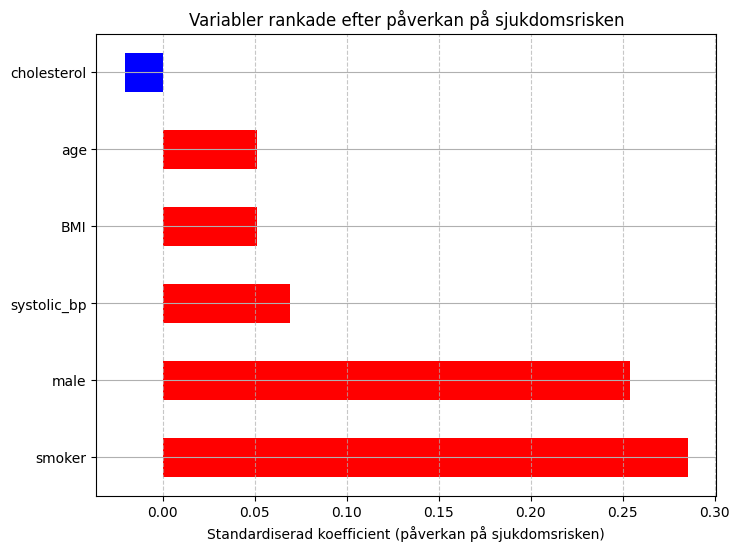

smoker         39.001714
male           34.722156
systolic_bp     9.434947
BMI             7.036564
age             6.981177
cholesterol     2.823442
dtype: float64


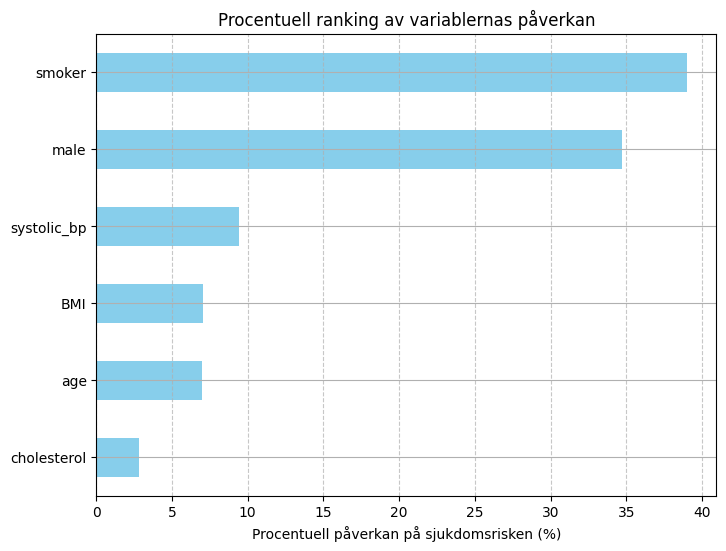

In [23]:

X = df_num[["age", "male", "systolic_bp", "cholesterol", "smoker", "BMI"]]
y = df["disease"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
model = LogisticRegression(solver='liblinear')
model.fit(X_scaled, y)
coefficients = pd.Series(model.coef_[0], index=X.columns).sort_values(key=abs, ascending=False)

#-----------------------------------
print(coefficients)

plt.figure(figsize=(8,6))
coefficients.plot(kind='barh', color=['red' if c>0 else 'blue' for c in coefficients])
plt.xlabel('Standardiserad koefficient (påverkan på sjukdomsrisken)')
plt.title('Variabler rankade efter påverkan på sjukdomsrisken')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

#-----------------------------------
abs_coef = coefficients.abs()
percent_impact = 100 * abs_coef / abs_coef.sum()
percent_impact_sorted = percent_impact.sort_values(ascending=True)

#-----------------------------------
print(percent_impact.sort_values(ascending=False))

plt.figure(figsize=(8,6))
percent_impact_sorted.plot(kind='barh', color='skyblue')
plt.xlabel('Procentuell påverkan på sjukdomsrisken (%)')
plt.title('Procentuell ranking av variablernas påverkan')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


In [24]:
X2 = sm.add_constant(X_scaled)
model_sm = sm.Logit(y, X2).fit()
print(model_sm.summary())


scores = cross_val_score(model, X_scaled, y, cv=10, scoring='roc_auc')
print(scores.mean(), scores.std())

Optimization terminated successfully.
         Current function value: 0.218211
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                disease   No. Observations:                  800
Model:                          Logit   Df Residuals:                      793
Method:                           MLE   Df Model:                            6
Date:                Thu, 27 Nov 2025   Pseudo R-squ.:                 0.02372
Time:                        09:55:50   Log-Likelihood:                -174.57
converged:                       True   LL-Null:                       -178.81
Covariance Type:            nonrobust   LLR p-value:                    0.2047
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.8562      0.162    -17.685      0.000      -3.173      -2.540
x1             0.0559      0.

smoker    0.288460
male      0.256856
BMI       0.053705
dtype: float64


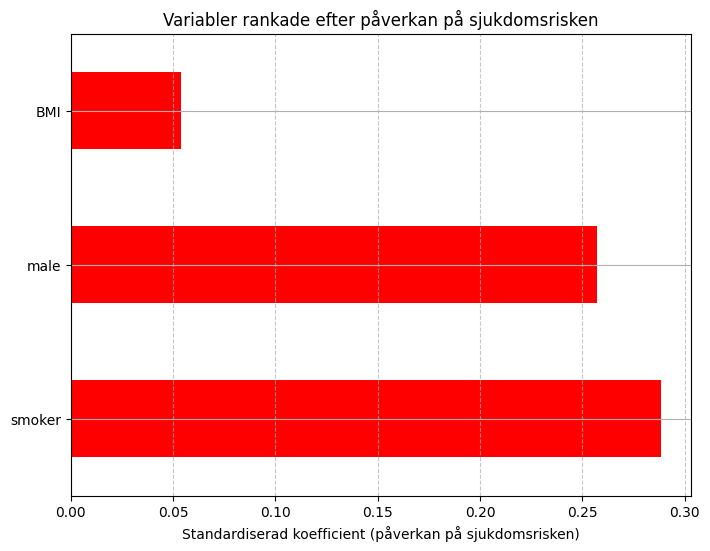

smoker    48.155173
male      42.879321
BMI        8.965506
dtype: float64


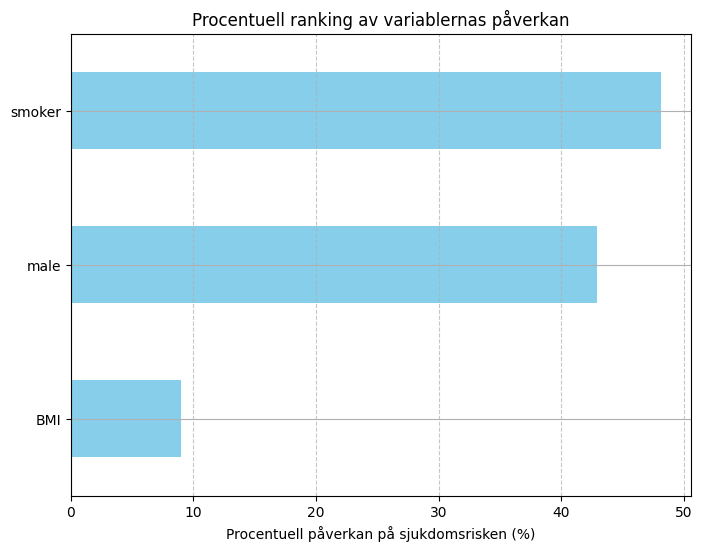

In [25]:

X = df_num[["male", "smoker", "BMI"]]
y = df["disease"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
model = LogisticRegression(solver='liblinear')
model.fit(X_scaled, y)
coefficients = pd.Series(model.coef_[0], index=X.columns).sort_values(key=abs, ascending=False)

#-----------------------------------
print(coefficients)

plt.figure(figsize=(8,6))
coefficients.plot(kind='barh', color=['red' if c>0 else 'blue' for c in coefficients])
plt.xlabel('Standardiserad koefficient (påverkan på sjukdomsrisken)')
plt.title('Variabler rankade efter påverkan på sjukdomsrisken')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

#-----------------------------------
abs_coef = coefficients.abs()
percent_impact = 100 * abs_coef / abs_coef.sum()
percent_impact_sorted = percent_impact.sort_values(ascending=True)

#-----------------------------------
print(percent_impact.sort_values(ascending=False))

plt.figure(figsize=(8,6))
percent_impact_sorted.plot(kind='barh', color='skyblue')
plt.xlabel('Procentuell påverkan på sjukdomsrisken (%)')
plt.title('Procentuell ranking av variablernas påverkan')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [26]:
X2 = sm.add_constant(X_scaled)
model_sm = sm.Logit(y, X2).fit()
print(model_sm.summary())

scores = cross_val_score(model, X_scaled, y, cv=10, scoring='roc_auc')
print(scores.mean(), scores.std())

Optimization terminated successfully.
         Current function value: 0.218526
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                disease   No. Observations:                  800
Model:                          Logit   Df Residuals:                      796
Method:                           MLE   Df Model:                            3
Date:                Thu, 27 Nov 2025   Pseudo R-squ.:                 0.02232
Time:                        09:55:50   Log-Likelihood:                -174.82
converged:                       True   LL-Null:                       -178.81
Covariance Type:            nonrobust   LLR p-value:                   0.04641
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.8511      0.161    -17.729      0.000      -3.166      -2.536
x1             0.2782      0.